In [1]:
## 패키지 로드
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib.ticker import ScalarFormatter # 숫자 표현
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
## 설정
# 스타일
plt.style.use('seaborn-v0_8-darkgrid')

# 폰트
from matplotlib import font_manager
font_path = "C:/Users/sangw/AppData/Local/Microsoft/Windows/Fonts/NanumSquareR.ttf"
font_manager.fontManager.addfont(font_path)
plt.rc('font', family='NanumSquare') # 한글 폰트 지정

# 데이터 프레임의 모든 레코드 출력
def print_all(obj, n=None):
    pd.set_option('display.max_row', n)
    display(obj)
    pd.set_option('display.max_row', 10)

# 모든 칼럼 출력
pd.set_option('display.max_columns', None)

In [3]:
# 기본 팔레트 색상 지정
custom_palette = [
    "#FF6F61",  # Coral/Orange (선명한 주황)
    "#6DBF9C",  # Teal (청록)
    "#F7C548",  # Bright Yellow (밝은 노랑)
    "#008080",  # Teal Blue (짙은 청록)
    "#FFB6C1",  # Light Pink (연한 분홍)
    "#4E79A7",  # Blue (짙은 파랑)
    "#9C755F",  # Taupe (갈색빛)
    "#FFD700"   # Gold (선명한 금색)
]


sns.set_palette(custom_palette)

## 데이터 로드

In [4]:
# 가계금융복지조사 데이터 로드 (Household Financial Welfare)
hfw_2023 = pd.read_csv('데이터세트/2023_가구마스터 [raw].csv', encoding='cp949')

### 데이터 기초 탐색

In [5]:
def summary_df(df):
    summary = pd.DataFrame({
    '변수명':df.columns,
    '변수타입':df.dtypes.values,
    '유니크값 수':df.nunique().values,
    '결측치 개수':df.isna().sum().values
    })
    return summary

In [6]:
print_all(summary_df(hfw_2023), None)


,변수명,변수타입,유니크값 수,결측치 개수
0,조사연도,int64,1,0
1,MD제공용_가구고유번호,int64,18094,0
2,가중값,float64,15250,0
3,수도권여부,object,2,0
4,가구주_성별코드,int64,2,0
5,가구원수,int64,10,0
6,노인가구여부,object,2,0
7,조손가구여부,object,2,0
8,한부모가구여부,object,2,0
9,다문화가구여부(2012년~),object,2,0


# 데이터 분석

In [7]:
hfw_df2 = hfw_2023.copy()

In [8]:
## 분석 대상 연령 범위: 중장년층(45~60세)
hfw_df2 = hfw_df2[hfw_df2['가구주_만연령'].between(45, 60)].reset_index(drop=True)

## 변수 조정
# - 사용할 변수들의 변수명 조정
hfw_df2.rename(columns={'경상소득(보완)':'연소득',
                        '자산':'총자산'}, inplace=True)

# - 파생 변수 생성
hfw_df2['금융자산비율'] = hfw_df2['자산_금융자산']/hfw_df2['총자산']
hfw_df2.loc[hfw_df2['금융자산비율'] > 1, '금융자산비율'] = 1
hfw_df2['거주주택비율'] = hfw_df2['자산_실물자산_부동산_거주주택금액']/hfw_df2['총자산']


# - 소득, 자산 20분위 수로 변경
hfw_df2['연소득_20분위'] = pd.qcut(hfw_df2['연소득'], 20, labels=False)+1
hfw_df2['총자산_20분위'] = pd.qcut(hfw_df2['총자산'], 20, labels=False)+1
hfw_df2['금융대출_20분위'] = pd.qcut(hfw_df2['총자산'], 20, labels=False)+1



## 결측치 제거
hfw_df2 = hfw_df2.dropna(subset=['연소득_20분위', '총자산_20분위', '금융자산비율', '거주주택비율']).reset_index(drop=True)

C:\Users\sangw\AppData\Local\Temp\ipykernel_6740\2239849197.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


(0.0, 31000.0)

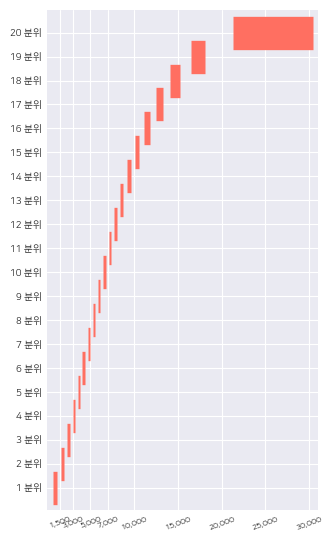

In [9]:
income_stats = hfw_df2.groupby('연소득_20분위')['연소득'].agg(
    mean='mean', 
    Q1=lambda x: x.quantile(0.25), 
    Q3=lambda x: x.quantile(0.75)
).reset_index()

income_stats['연소득_20분위'] = income_stats['연소득_20분위'].astype(str) + ' 분위'

# 에러바 범위 계산
income_stats['yerr'] = income_stats['Q3'] - income_stats['Q1']

# 시각화
plt.figure(figsize=(3.5, 6.5))
plt.errorbar(
    y=income_stats['연소득_20분위'].astype(str), 
    x=income_stats['mean'], 
    xerr=[income_stats['mean'] - income_stats['Q1'], income_stats['Q3'] - income_stats['mean']], 
    fmt='o',             # 포인트 모양
   # ecolor='gray',       # 에러바 색상
    capsize=0,           # 에러바의 끝부분 캡 크기
    elinewidth=24,        # 에러바 선 두께
    marker='o',          # 포인트 모양
    markersize=0,        # 포인트 크기
    label='연소득 평균 및 IQR (Q1-Q3)'
)

# y축 값 폰트 사이즈 설정
plt.yticks(fontsize=7)

# X축 틱 설정
_ = plt.xticks(ticks=[1500, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000], rotation=20, fontsize=6)

# x축 값에 쉼표 추가 포맷 설정
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))


# 타이틀
plt.title('')

plt.xlim(0, 31000)

C:\Users\sangw\AppData\Local\Temp\ipykernel_17340\3917804856.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


(0.0, 350000.0)

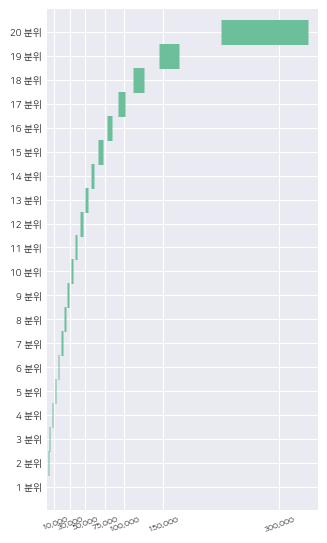

In [ ]:
asset_stats = hfw_df2.groupby('총자산_20분위')['총자산'].agg(
    mean='mean', 
    Q1=lambda x: x.quantile(0.25), 
    Q3=lambda x: x.quantile(0.75)
).reset_index()

asset_stats['총자산_20분위'] = asset_stats['총자산_20분위'].astype(str) + ' 분위'

# 에러바 범위 계산
asset_stats['yerr'] = asset_stats['Q3'] - asset_stats['Q1']

# 시각화
plt.figure(figsize=(3.5, 6.5))
plt.errorbar(
    y=asset_stats['총자산_20분위'].astype(str), 
    x=asset_stats['mean'], 
    xerr=[asset_stats['mean'] - asset_stats['Q1'], asset_stats['Q3'] - asset_stats['mean']], 
    fmt='o',             # 포인트 모양
    ecolor='#6DBF9C',       # 에러바 색상
    capsize=0,           # 에러바의 끝부분 캡 크기
    elinewidth=18,        # 에러바 선 두께
    marker='o',          # 포인트 모양
    markersize=0,        # 포인트 크기
    label='연소득 평균 및 IQR (Q1-Q3)'
)

# y축 값 폰트 사이즈 설정
plt.yticks(fontsize=7)

# X축 틱 설정
_ = plt.xticks(ticks=[10000, 30000, 50000, 75000, 100000, 150000, 300000], rotation=20, fontsize=6)


# x축 값에 쉼표 추가 포맷 설정
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# 타이틀
plt.title('')

# x축 범위
plt.xlim(0, 350000)


In [ ]:
## 스케일 조정(0~1 사이로)
# - 스케일 조정 대상 변수
scale_vars = ['연소득_20분위', '총자산_20분위']

norm_scaler = MinMaxScaler()
clustering_df = pd.DataFrame(norm_scaler.fit_transform(hfw_df2[scale_vars]), columns=scale_vars)
clustering_df['금융자산비율'] = hfw_df2['금융자산비율']


In [ ]:
## K=7 군집 분석 수행
Kbest = KMeans(n_clusters=7, random_state=802, n_init=10)
hfw_df2['cluster'] = Kbest.fit_predict(clustering_df)
cluster7_res = hfw_df2.groupby('cluster', as_index=False)[['연소득', '총자산', '금융자산비율', '거주주택비율', '부채']].mean()
cluster7_res['사이즈'] = hfw_df2.groupby('cluster').size()
cluster7_res = cluster7_res.sort_values('총자산', ascending=False)

In [ ]:
# 군집별 평균 소득, 자산, 금융자산비율
cluster7_res

,cluster,연소득,총자산,금융자산비율,거주주택비율,부채,사이즈
2,2,15796.900164,143845.522095,0.160574,0.508043,25472.691489,1222
4,4,15885.733491,100131.603774,0.588651,0.222546,9198.577830,424
0,0,5425.255668,79960.154912,0.150856,0.540398,14481.147355,794
3,3,9200.628178,33559.901483,0.206104,0.587978,6948.082627,944
5,5,7710.073129,18816.258503,0.823392,0.033421,3375.039116,588
6,6,3669.421649,18042.802062,0.210004,0.531112,3368.881443,970
1,1,2722.328173,5870.876161,0.932800,0.004005,1474.955624,969


In [ ]:
hfw_df2['금융행동유형'] = hfw_df2['cluster'].map({
    2:'유형1', # 초고소득 & 부동산 투자비율 높음
    4:'유형2', # 초고소득 & 저축 및 금융 상품 투자 비율 높음
    0:'유형3', # 중간소득 & 자산 높음 & 부동산 투자 비율 높음
    3:'유형4', # 중상위 소득 & 저축 및 금융 상품 투자 비율 높음
    5:'유형5', # 중상위 소득 & 부동산 투자 비율 높음
    6:'유형6', # 중하위 소득 & 부동산 투자비율 높음
    1:'유형7' # 저소득
})

In [ ]:
cluster_bubble_df = hfw_df2.groupby('금융행동유형', as_index=False)[['연소득', '총자산', '금융자산비율']].mean()
cluster_bubble_df['실물자산투자비율'] = 1-cluster_bubble_df['금융자산비율']

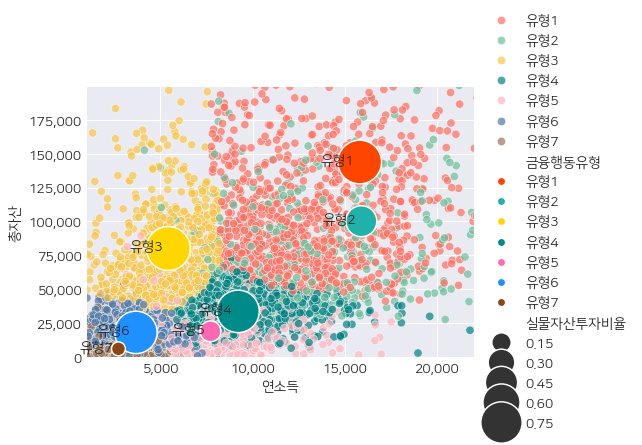

In [ ]:
# 차트 사이즈 조정
plt.figure(figsize=(5, 3.5))

# 전체 레코드 스캐터플롯 먼저 그리기
sns.scatterplot(
    data=hfw_df2,
    x='연소득',
    y='총자산',
    hue='금융행동유형',
    hue_order=['유형1', '유형2', '유형3', '유형4', '유형5', '유형6', '유형7'],
    alpha=0.7
)

# 유형별 평균 스캐터플롯 그리기
scatter = sns.scatterplot(
    x=cluster_bubble_df['연소득'],
    y=cluster_bubble_df['총자산'],
    size=cluster_bubble_df['실물자산투자비율'],
    sizes=(100, 1000),
    hue=cluster_bubble_df['금융행동유형'],
    palette={
        '유형1':"#FF4500",
        '유형2':"#20B2AA",
        '유형3':"#FFD700",
        '유형4':"#008B8B",
        '유형5':"#FF69B4",
        '유형6':"#1E90FF",
        '유형7':"#8B4513"
    },
    edgecolor='white'
)

# 차트 범위 설정
plt.xlim(1000, 22000)
plt.ylim(0000, 199000)
plt.xticks([5000, 10000, 15000, 20000])

# y축 값에 쉼표 추가 포맷 설정
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))


# x축 값에 쉼표 추가 포맷 설정
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))


# 금융자산유형 텍스트 표시
for i in range(len(cluster_bubble_df)):
    plt.text(
        cluster_bubble_df['연소득'][i] - 300,  
        cluster_bubble_df['총자산'][i] - 2000,         
        str(cluster_bubble_df['금융행동유형'][i]),       
        fontsize=10,                            
        ha='right'                             
    )

# 범례를 플롯 오른쪽에 배치
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 


**유형 1**
- 성향: 초고소득자, 자산 수준 매우 높으며 부동산에 대한 강한 의존.
- 서비스 전략
    - 부동산 투자 시 필요한 대출 상품을 맞춤형으로 제공하여 유연한 상환 조건 및 저금리 혜택을 적용 가능.
    - 세무 상담 및 부동산 투자 자문 서비스 제공.

**유형 2**
- 성향: 초고소득자, 저축 및 금융 자산 투자 비율이 높음. 자산 관리 및 세금 효율화 관심이 많을 것.
- 서비스 전략
    - 개인 맞춤형 재무 계획 수립, 세무 전략 및 자산 배분 상담 등 재무 설계 서비스 제공.
    - 주식, 펀드, ETF 등 다양한 금융 상품 제안. 위험 분산을 위한 자산 포트폴리오 설계.
    - 자산 형성을 위한 연금 상품 및 은퇴 후 자산 관리에 대한 상담 제공.

**유형 3**
- 성향: 공격적인 부동산 투자 성향, 대출 의존도가 높음.
- 서비스 전략
    - 높은 이자율의 대출 상환을 위한 리파이낸싱 제안으로 이자 부담 완화.

**유형 4**
- 성향: 중상위 소득자, 안정적인 주거 자산 보유.
- 서비스 전략
    - 유연한 상환 옵션과 저금리 주택담보대출 상품 제공.
    - 안정적인 금융 상품(예: 적립식 펀드, 채권) 및 자산 증식 전략 제안.

**유형 5**
- 성향: 중상위 소득자, 저축 등 금융 자산 집중, 안정적이고 보수적인 자산 관리.
- 서비스 전략
    - 고수익 저축 상품 및 금융 투자 상품 제공.
    - 세금 효율적인 투자 및 저축 전략 제공.
    - 은퇴 계획을 위한 장기적인 재무 목표 설정 및 자산 관리 전략 수립

**유형 6**
- 성향: 중하위 소득자, 안정적인 주거 및 저축을 통한 자산 보호.
- 서비스 전략
    - 금융 이해도를 높이는 재무 교육 프로그램 등 제공
    - 안정적인 저축 상품 및 소액 투자 상품 제안.

**유형 7**
- 성향: 저소득자, 대부분의 자산은 저축으로 보유, 주택 보유X
- 서비스 전략
    - 기본 저축 상품 제공
    - 정부나 비영리 기관 지원 프로그램 안내 등 정보 제공
